In [315]:
import casadi as ca
import numpy as np


pos     = ca.MX.sym('pos', 3)
q       = ca.MX.sym('q', 4)
vel     = ca.MX.sym('vel', 3)
w       = ca.MX.sym('w', 3)
u       = ca.MX.sym('u', 4)
aero_drag = 0.8
m = 1.0
payload_mass = 0.01
drag =1

l = 0.5  #arm length
k = 0.01  # moment constant

# Moments of inertia
J1, J2, J3 = 0.03, 0.03, 0.06

# Create a CasADi diagonal matrix for J
J = ca.diag([J1, J2, J3])

# Define the skew-symmetric matrix function
skew_symmetric_matrix = ca.vertcat(
    ca.horzcat(0, -w[2], w[1], w[0]),
    ca.horzcat(w[2], 0, -w[0], w[1]),
    ca.horzcat(-w[1], w[0], 0, -w[2]),
    ca.horzcat(-w[0], -w[1], w[2], 0)
)

# Create a CasADi Function object for the 4x4 skew-symmetric matrix
skew_symmetric_func_4x4 = ca.Function('skew_symmetric_func_4x4', [w], [skew_symmetric_matrix])

pos_dot = vel

qw = q[0]
qx = q[1]
qy = q[2]
qz = q[3]

# Define the elements of the rotation matrix
r11 = 1 - 2*qy**2 - 2*qz**2
r12 = 2*qx*qy - 2*qz*qw
r13 = 2*qx*qz + 2*qy*qw

r21 = 2*qx*qy + 2*qz*qw
r22 = 1 - 2*qx**2 - 2*qz**2
r23 = 2*qy*qz - 2*qx*qw

r31 = 2*qx*qz - 2*qy*qw
r32 = 2*qy*qz + 2*qx*qw
r33 = 1 - 2*qx**2 - 2*qy**2

# Create a CasADi MX matrix for the rotation matrix
rot_matrix = ca.vertcat(
    ca.horzcat(r11, r12, r13),
    ca.horzcat(r21, r22, r23),
    ca.horzcat(r31, r32, r33)
)

a_thrust  = ca.vertcat(0, 0, ca.sum1(u)) / m
if(drag == 1):
    v_b = ca.mtimes(rot_matrix.T, vel)
    a_drag = -aero_drag * v_b**2 * ca.sign(v_b)/m
    rotor_drag_xy = 0.3
    rotor_drag_z = 0.0
    rotor_drag = ca.vertcat([rotor_drag_xy, rotor_drag_xy, rotor_drag_z])
    a_drag += -rotor_drag * v_b/m

    a_drag_world = ca.mtimes(rot_matrix,a_drag)
else:
    a_drag_world = ca.vertcat(0, 0, 0)

gravity   = ca.vertcat(0, 0, 9.81)
a_payload = -payload_mass * gravity/m


vel_dot = -gravity + ca.mtimes(rot_matrix,a_thrust) + a_payload + a_drag_world
# Attitude dynamics
q_dot = 0.5 * ca.mtimes(skew_symmetric_func_4x4(w), q)

n = ca.vertcat( (l*(u[0] - u[1] - u[2] + u[3])/2**0.5), (l*(-u[0] - u[1] + u[2] + u[3])/2**0.5) , (k*(u[0] - u[1] + u[2] - u[3])))

w_dot = ca.vertcat(
        1 / J1 * (n[0] + (J2 - J3) * w[1] * w[2]),
        1 / J2 * (n[1] + (J3 - J1) * w[2] * w[0]),
        1 / J3 * (n[2] + (J1 - J2) * w[0] * w[1])
    )


In [316]:
state = ca.vertcat(pos, q, vel, w)
state_dot = ca.vertcat(pos_dot, q_dot, vel_dot, w_dot)

dynamics_func = ca.Function('dynamics_func', [state, u], [state_dot])


initial_state = ca.vertcat([0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])


In [317]:
T = 5
N = 20

intg_options = {}
intg_options['tf'] = T/N
intg_options['simplify'] = True
intg_options['number_of_finite_elements'] = 10

ode = {}
ode['x'] = state
ode['u'] = u
ode['ode'] = dynamics_func(state, u)

intg = ca.integrator('intg', 'rk', ode, intg_options)

ini_u = ca.vertcat(5,1,1,1)

In [318]:
res = intg(x0 = state, u= u)
next_state = res['xf'] 

# print(state.type)
F = ca.Function('F',[state,u],[next_state],['state','u'],['next_state'])
sim = F.mapaccum(N)
u_values = np.random.uniform(0, 5, (N, 4))
print(u_values.shape)
u_values = np.zeros((N,4))

print(u_values.shape)

(20, 4)
(20, 4)


(13, 21)


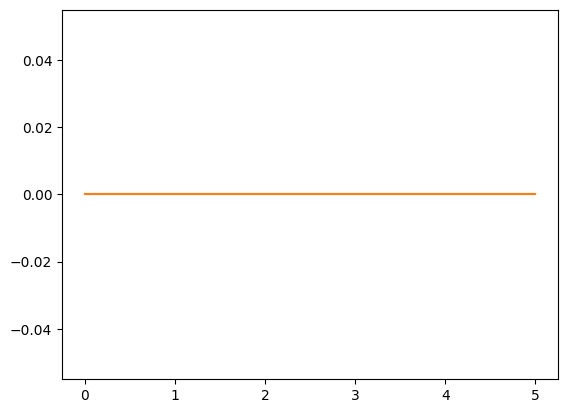

In [319]:
x0 = initial_state
res = sim(x0,u_values.T)

plt.figure
tgrid = ca.linspace(0,T,N+1)
i = 10
full = ca.horzcat(x0,res)
print(full.shape)
plt.plot(tgrid,full[i,:].T)
tgrid = ca.linspace(0,T,N)
plt.plot(tgrid,res[i,:].T)
# plt.plot(tgrid,res[1,:].T)
# plt.plot(tgrid,res[2,:].T)
# plt.plot(res[2,:10])
# print(res[2,:10])

In [320]:
U = ca.MX.sym('U',4,N)
X1 = sim(x0,U)[1,:]
print(X1.shape)
J = ca.jacobian(X1,U)
print(J.shape)
print(X1.shape)

(1, 20)
(20, 80)
(1, 20)


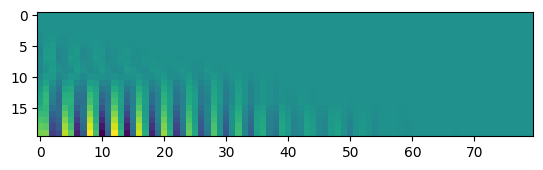

In [321]:
Jf = ca.Function('Jf',[U],[J])
u_values = np.random.uniform(0, 5, (N, 4))
plt.imshow(Jf(u_values.T).full())

In [322]:
Jf(u_values.T)

DM(
[[-0.0018623, 0.00329352, 0.00120078, ..., 00, 00, 00], 
 [-0.0261969, 0.0569137, 0.0210265, ..., 00, 00, 00], 
 [-0.058753, 0.0826205, 0.0447982, ..., 00, 00, 00], 
 ...,
 [11.153, 10.3025, -12.0776, ..., 00, 00, 00], 
 [13.3107, 12.5066, -14.5422, ..., 00, 00, 00], 
 [15.1706, 15.6215, -16.6984, ..., -0.0181644, -0.00610273, -0.0124312]])

In [352]:

opti = ca.Opti()
x = opti.variable(13,N+1)
u = opti.variable(4,N)
p = opti.parameter(13,1)


cost = ca.sumsqr(x)+ca.sumsqr(u)
opti.minimize(cost)

# equality constraints
for k in range(N):

    opti.subject_to(x[:,k+1] == F(x[:,k],u[:,k]))

opti.subject_to(x[:, 20] == p)
opti.subject_to(x[:, 0] == p)

#inequality constraints
opti.subject_to(opti.bounded(0, u, 5))

opti.set_value(p, initial_state)

opti.solver('ipopt')  # Choose your solver
opti.solve()

# Retrieve the optimized variables
x_opt = opti.value(x)
u_opt = opti.value(u)




This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3286
Number of nonzeros in inequality constraint Jacobian.:       80
Number of nonzeros in Lagrangian Hessian.............:     2173

Total number of variables............................:      353
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      286
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       80
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.14e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

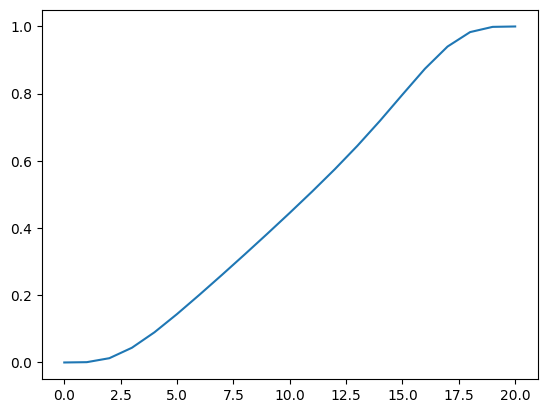

In [349]:
x_opt = opti.value(x)
u_opt = opti.value(u)
p_opt = opti.value(p)

plt.plot(x_opt[0,:])

[2.51625256 2.55069512 2.53400884 2.51740809 2.50643144 2.50113528
 2.49852353 2.49673907 2.49529414 2.49415253 2.49331835 2.49268008
 2.49184951 2.49004943 2.48597894 2.47758614 2.46386852 2.44296695
 2.40320915 2.37990188]


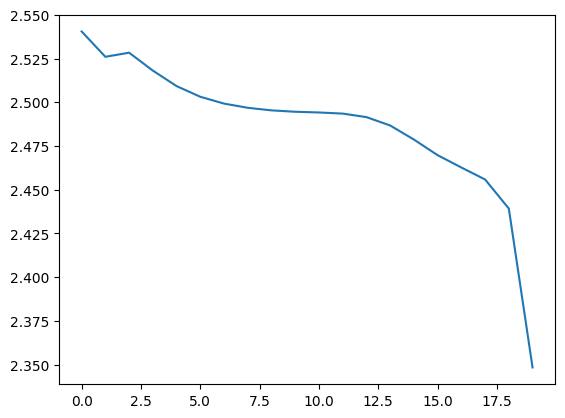

In [350]:
plt.plot(u_opt[1,:])
print(u_opt[2,:])